# 05 - Pix2Pix Inference

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

from botocore.exceptions import ClientError
import boto3
# import calendar
import io
from itertools import product
import numpy as np
import os
import pandas as pd
# import random
from sklearn.model_selection import train_test_split
import tifffile as tif
from tqdm import tqdm

import torch
import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms

# from models.pix2pix_model import Pix2PixModel

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
RANDOM_STATE=42

### Create train, validation, test splits

In [5]:
%cd ~/projects/dd-biomassters
df_metadata = pd.read_csv("data/metadata/features_metadata.csv",index_col=0)
all_chips = list(df_metadata.chip_id.unique())
train_chips = list(df_metadata[df_metadata.split=='train'].chip_id.unique())
test_chips = list(df_metadata[df_metadata.split=='test'].chip_id.unique())

df_metadata_train = df_metadata[df_metadata.split=='train'].chip_id \
    .drop_duplicates().reset_index(drop=True).to_frame()

X_train, X_validation = train_test_split(df_metadata_train, test_size=0.33, random_state=RANDOM_STATE)
df_metadata.loc[df_metadata.chip_id.isin(X_validation.chip_id), 'split'] = 'validation'

/Users/loaner/projects/dd-biomassters


### Check for data completeness

In [110]:
chips = all_chips
satellites = ['S1', 'S2']
months = range(1,13)
df_metadata_complete = pd.DataFrame(list(product(chips, satellites, months)), columns=['chip_id', 'satellite', 'month'])
df_metadata_complete = df_metadata_complete.merge(df_metadata, on=['chip_id', 'satellite', 'month'], how='left')

# chip aggregates
df_metadata_complete['file_exists'] = df_metadata_complete.apply(lambda row: type(row.filename) == str, axis=1)
df_agg = df_metadata_complete.groupby('chip_id').agg(
    {
        'file_exists': pd.Series.all,
        'num_s1_missing': sum, 
        'num_s2_obscured': sum
    }
).reset_index()
df_agg_s1 = df_metadata_complete[df_metadata_complete.satellite=='S1'].groupby('chip_id').agg(
    {
        'file_exists': pd.Series.all,
        'num_s1_missing': sum
    }
).reset_index()
df_agg_s2 = df_metadata_complete[df_metadata_complete.satellite=='S2'].groupby('chip_id').agg(
    {
        'file_exists': pd.Series.all,
        'num_s2_obscured': sum
    }
).reset_index()

# completeness criteria
complete_chips = df_agg[(df_agg.file_exists)&(df_agg.num_s1_missing==0)&(df_agg.num_s2_obscured==0)].chip_id.to_list()
complete_s1_chips = df_agg_s1[(df_agg_s1.file_exists)&(df_agg_s1.num_s1_missing==0)].chip_id.to_list()
complete_s2_chips = df_agg_s2[(df_agg_s2.file_exists)&(df_agg_s2.num_s2_obscured==0)].chip_id.to_list()

# add to original
df_metadata['is_complete'] = df_metadata.chip_id.isin(complete_chips)
df_metadata['is_complete_s1'] = df_metadata.chip_id.isin(complete_s1_chips)
df_metadata['is_complete_s2'] = df_metadata.chip_id.isin(complete_s2_chips)

# summary stats
df_metadata[['chip_id', 'split', 'is_complete']].drop_duplicates().groupby(['split', 'is_complete']).count()

chip_id
split      is_complete         
test       False           2566
           True             207
train      False           5482
           True             339
validation False           2699
           True             169

In [111]:
df_metadata.to_csv(f"data/metadata/features_metadata_split_{RANDOM_STATE}.csv")

## Download train data to local

In [115]:
class DataDownloader():
    S3_BUCKET_NAME = 'drivendata-competition-biomassters-public-us'
    IMG_SIZE = 256, 256
    RANDOM_STATE = 42

    def __init__(self, phase, dataroot, dataset_size, chip_is_complete):
        
        self.phase = phase
        self.dataroot = dataroot
        self.dataset_size = dataset_size

        # prepare metadata
        self.metadata = pd.read_csv(f"{self.dataroot}/metadata/features_metadata_split_42.csv",index_col=0)
        if chip_is_complete:
            self.metadata = self.metadata[self.metadata.is_complete]
        self.data = self.metadata[self.metadata.split == self.phase] \
            .chip_id.drop_duplicates().reset_index(drop=True).to_frame()
        if self.dataset_size < len(self.data):
            self.data = self.data.sample(self.dataset_size, random_state=self.RANDOM_STATE).reset_index(drop=True)

        self.images = []
        self.__initialize_s3()
    
    def __initialize_s3(self):
        """Initalize AWS s3 bucket for 
        """
        s3_resource = boto3.resource(
            's3',
            aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
            aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY']
        )
        self.s3_bucket = s3_resource.Bucket(self.S3_BUCKET_NAME)

    def run(self):
        for i, row in self.data.iterrows():
            print(i, row.chip_id)
            X = self.__load_chip_feature_data(row['chip_id'])
            y = self.__load_chip_target_data(row['chip_id'])
            self.images.append({'chip_id': row['chip_id'], 'X': X, 'y': y})

    def __get_chip_metadata(self, chip_id):
        return self.metadata[self.metadata.chip_id==chip_id]
            
    def __load_chip_feature_data(self, chip_id):
        img_channels = []
        for _, row in self.__get_chip_metadata(chip_id).iterrows():
            
            if type(row.filename) != str:
                print(row)
                if row.satellite=='S1':
                    print('Missing S1')
                    img = self.dummy_s1_missing_img
                elif row.satellite=='S2':
                    print('Missing S2')
                    img = self.dummy_s2_missing_img
                else:
                    raise ValueError("Unknown satellite value")
            else:
                s3_key = f"{'test' if self.phase=='test' else 'train'}_features/{row.filename}"
                img = self.__load_tif(self.s3_bucket, s3_key, out_path=f'{self.dataroot}/{s3_key}')
            img_channels.append(img)
        return np.concatenate(img_channels, axis=2)

    def __load_chip_target_data(self, chip_id):
        filename = self.__get_chip_metadata(chip_id).corresponding_agbm.iloc[0]
        s3_key = f'train_agbm/{filename}'
        img = self.__load_tif(self.s3_bucket, s3_key, out_path=f'{self.dataroot}/{s3_key}')
        return img
    
    def __load_tif(self, s3_bucket, key, out_path):
        if not os.path.exists(out_path):
            self.download_obj_from_s3(s3_bucket, key, out_path)
        img = tif.imread(out_path)
        return img

    def download_obj_from_s3(self, s3_bucket, key, out_path):
        try:
            s3_bucket.download_file(key, out_path)
        except ClientError as e:
            if e.response['Error']['Code'] == "404":
                print("The object does not exist.")
            else:
                raise

In [349]:
%cd /Users/loaner/projects/dd-biomassters/
dd = DataDownloader(phase='train', dataroot='data/', dataset_size=200, chip_is_complete=True)
dd.run()

/Users/loaner/projects/dd-biomassters
0 dbe9a663
1 584e3e68
2 55a14920
3 25fd4e5d
4 63d80a6c
5 baacf334
6 91f65529
7 d7a3a181
8 fec09d0b
9 14d3b92b
10 5fe2bef0
11 b2c401d0
12 cd588d96
13 7af9ab75
14 51e245a8
15 874dde20
16 5957a5cc
17 f5279346
18 d10d20b5
19 0636b264
20 d8ae34f2
21 30617afb
22 819bfa10
23 5a1bc9dd
24 75e80cb9
25 4618c2da
26 51d93376
27 a9ee85c3
28 7164a926
29 ef683082
30 8dbdd885
31 23159416
32 4f349d09
33 ef957a4d
34 3f56d3a1
35 04b380c7
36 e8ab54e7
37 f707aaad
38 5209306d
39 3e398cfe
40 42b5ac06
41 02c460be
42 7c768708
43 b958c3fb
44 28e70767
45 ef699037
46 dcfb6072
47 e23ad4d7
48 3abcf82c
49 1d98f768
50 f11ecfea
51 9353eb6d
52 a5289942
53 42252aa2
54 35e67e33
55 a01646fd
56 30fcd658
57 f822769e
58 fb48851a
59 27c33457
60 eb4f944d
61 ebac9596
62 f016331a
63 893c3cd5
64 a759e918
65 3abc0182
66 3d92ead9
67 0ad475a1
68 36bb6861
69 572306c5
70 04debe47
71 70dbbfd2
72 f5d934ef
73 e98df0c5
74 e3a3dba4
75 3e4eba43
76 76e4ec0c
77 a072b45b
78 cafffd1d
79 3411cc89
80 4c268cf7


In [282]:
yy = np.concatenate([data['y'] for data in dd.images])
mean = yy.mean()
std = yy.std()
print(yy.shape, mean, std)
yy_scaled = (yy-mean)/std * .5 + .5
print(yy_scaled.mean(), yy_scaled.std())

yy_scaled_invert = ((yy_scaled - .5) / .5 * std) + mean
print(yy_scaled_invert.mean(), yy_scaled_invert.std())

(12800, 256) -12.469111 3.4001684
0.5000004 0.4999999
-12.469111 3.4001684


(0.0, 0.574639, 0.0068725203, 0.008914556)

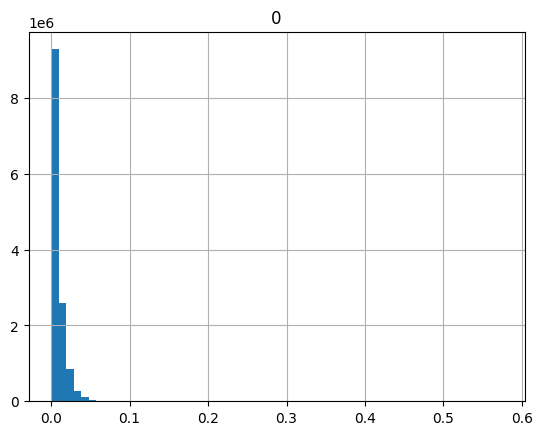

In [367]:
y_list = [data['y'] for data in dd.images]
y_flat = np.concatenate(y_list).flatten()
y_max=1e4
y_flat = y_flat/y_max
df = pd.DataFrame(y_flat)
df.hist(bins=60)
min(y_flat), max(y_flat), np.mean(y_flat), np.std(y_flat)
# y_t = (y_flat-.5) / .5
# min(y_t), max(y_t), np.mean(y_t), np.std(y_t)

In [300]:
yy = np.stack([data['X'][:,:,:4] for data in dd.images])
mean = np.mean(yy, axis=(0,1,2))
std = np.std(yy, axis=(0,1,2))
print(yy.shape, 'mean:', mean, 'std:', std)
# yy_scaled = (yy-mean)/std * .5 + .5
# print(yy_scaled.mean(), yy_scaled.std())

# yy_scaled_invert = ((yy_scaled - .5) / .5 * std) + mean
# print(yy_scaled_invert.mean(), yy_scaled_invert.std())

(50, 256, 256, 4) mean: [-12.47562  -19.737421 -12.25755  -19.234262] std: [3.3957279 4.483836  4.1778703 5.884509 ]


In [308]:
X_mean = [-12.47562, -19.737421, -12.25755, -19.234262]
X_std = [3.3957279, 4.483836, 4.1778703, 5.884509 ]
X = data['X'][:,:,:4]
for d, (m, s) in enumerate(zip(X_mean, X_std)):
    print(m,s)
    X[:,:,d] = (X[:,:,d] - m) / s

-12.47562 3.3957279
-19.737421 4.483836
-12.25755 4.1778703
-19.234262 5.884509


In [316]:
# data['X'][:,:,:4].shape
X.mean()

0.21489711

array([[<AxesSubplot: title={'center': '0'}>]], dtype=object)

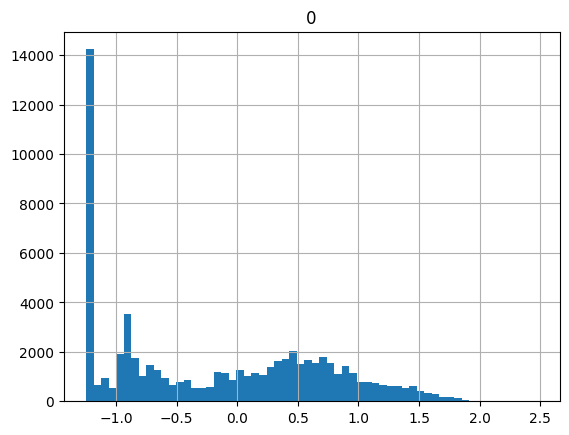

In [248]:
y_list = [data['y'] for data in dd.images]
y_flat = np.concatenate(y_list[:1]).flatten()
y_flat = (y_flat - mean) / std
y_flat = np.log(y_flat+1)
df = pd.DataFrame(y_flat)
# df[df>0].hist(bins=100)
df.hist(bins=60)
# df.hist(bins=np.arange(-1,15,.1))

In [26]:
%cd /Users/loaner/projects/dd-biomassters

/Users/loaner/projects/dd-biomassters


## Test via command line interface

## Train dev

In [388]:
%cd /Users/loaner/projects/dd-biomassters
!python ./pix2pix/train.py \
    --dataroot ./data --name biomassters_softplus_b3p0 --model pix2pix --phase train --gpu_ids -1 \
    --direction AtoB --input_nc 4 --output_nc 1 --dataset_mode biomassters --preprocess "" --no_flip  \
    --batch_size 10 --max_dataset_size 100 \
    --n_epochs 100 --n_epochs_decay 100 --lr 0.0002 \
    --display_id 1 --display_freq 100 --print_freq 100 --update_html_freq 100 --save_epoch_freq 5 \

/Users/loaner/projects/dd-biomassters
----------------- Options ---------------
               batch_size: 10                            	[default: 1]
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./data                        	[default: data]
             dataset_mode: biomassters                   	[default: aligned]
                direction: AtoB                          
              display_env: main                          
             display_freq: 100                           	[default: 400]
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256               

real_A shape: torch.Size([10, 4, 256, 256]) max: 7.8842535 mean: 0.45701584 min: -6.2594895
fake_B shape: torch.Size([10, 1, 256, 256]) max: 4.073519 mean: 0.87168294 min: 3.007041e-05
real_B shape: torch.Size([10, 1, 256, 256]) max: 50.913292 mean: 1.2124332 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 258.32492 mean: 55.278343 min: 0.001906935
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 3228.7 mean: 76.88727 min: 0.0
RMSE: 71.717094
saving html
(epoch: 6, iters: 100, time: 1.221, data: 11.741) G_GAN: 1.195 G_L1: 63.565 D_real: 0.549 D_fake: 0.454 
End of epoch 6 / 200 	 Time Taken: 154 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 5.9119744 mean: 0.18037257 min: -3.6275392
fake_B shape: torch.Size([10, 1, 256, 256]) max: 3.6207848 mean: 0.8982588 min: 0.00022215101
real_B shape: torch.Size([10, 1, 256, 256]) max: 73.918175 mean: 0.9775276 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 

fake_B shape: torch.Size([10, 1, 256, 256]) max: 7.0631714 mean: 0.9600035 min: 1.1021207e-06
real_B shape: torch.Size([10, 1, 256, 256]) max: 50.913292 mean: 1.260802 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 447.91568 mean: 60.87925 min: 6.9891714e-05
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 3228.7 mean: 79.95459 min: 0.0
RMSE: 64.43398
saving html
(epoch: 18, iters: 100, time: 1.210, data: 9.757) G_GAN: 1.169 G_L1: 58.067 D_real: 0.519 D_fake: 0.433 
End of epoch 18 / 200 	 Time Taken: 151 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 7.994336 mean: 0.49832186 min: -3.865085
fake_B shape: torch.Size([10, 1, 256, 256]) max: 6.647507 mean: 0.9407457 min: 5.192513e-06
real_B shape: torch.Size([10, 1, 256, 256]) max: 73.918175 mean: 1.0174105 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 421.55606 mean: 59.658012 min: 0.00032928665
real_B_inverted shape: torch.Size([10, 1, 256, 256

saving html
(epoch: 30, iters: 100, time: 1.375, data: 14.399) G_GAN: 1.277 G_L1: 41.025 D_real: 0.522 D_fake: 0.185 
saving the model at the end of epoch 30, iters 3000
End of epoch 30 / 200 	 Time Taken: 172 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 5.5547905 mean: 0.67459327 min: -3.8647614
fake_B shape: torch.Size([10, 1, 256, 256]) max: 7.1307707 mean: 1.0577368 min: 2.218003e-08
real_B shape: torch.Size([10, 1, 256, 256]) max: 58.405605 mean: 1.2365239 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 452.20255 mean: 67.07707 min: 1.4065613e-06
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 3703.83 mean: 78.41498 min: 0.0
RMSE: 54.01496
saving html
(epoch: 31, iters: 100, time: 1.457, data: 15.192) G_GAN: 2.004 G_L1: 47.616 D_real: 0.188 D_fake: 0.456 
End of epoch 31 / 200 	 Time Taken: 176 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 7.587265 mean: 0.34680003

RMSE: 63.889614
saving html
(epoch: 42, iters: 100, time: 1.314, data: 12.241) G_GAN: 2.715 G_L1: 52.799 D_real: 0.142 D_fake: 0.069 
End of epoch 42 / 200 	 Time Taken: 159 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 7.587265 mean: 0.2131106 min: -4.051862
fake_B shape: torch.Size([10, 1, 256, 256]) max: 10.844383 mean: 1.0451527 min: 4.3528928e-10
real_B shape: torch.Size([10, 1, 256, 256]) max: 44.738163 mean: 1.1198515 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 687.70374 mean: 66.279045 min: 2.7604157e-08
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 2837.1 mean: 71.01613 min: 0.0
RMSE: 46.414864
saving html
(epoch: 43, iters: 100, time: 1.250, data: 12.769) G_GAN: 1.830 G_L1: 38.368 D_real: 0.208 D_fake: 0.261 
End of epoch 43 / 200 	 Time Taken: 153 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 10.11356 mean: 0.29713455 min: -3.6275392
fake_B shape: torch.

saving html
(epoch: 54, iters: 100, time: 1.242, data: 10.080) G_GAN: 1.999 G_L1: 34.516 D_real: 0.281 D_fake: 0.040 
End of epoch 54 / 200 	 Time Taken: 156 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 8.600046 mean: 0.33450952 min: -3.2836716
fake_B shape: torch.Size([10, 1, 256, 256]) max: 19.423702 mean: 1.0514146 min: 6.4152984e-16
real_B shape: torch.Size([10, 1, 256, 256]) max: 74.41238 mean: 1.0076424 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 1231.767 mean: 66.67616 min: 4.068304e-14
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 4718.91 mean: 63.900307 min: 0.0
RMSE: 47.873756
saving html
(epoch: 55, iters: 100, time: 1.261, data: 13.016) G_GAN: 3.670 G_L1: 37.679 D_real: 0.083 D_fake: 0.025 
saving the model at the end of epoch 55, iters 5500
End of epoch 55 / 200 	 Time Taken: 157 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 10.11356 mean: 0.28374332 

saving html
(epoch: 66, iters: 100, time: 1.295, data: 12.764) G_GAN: 3.036 G_L1: 38.367 D_real: 0.087 D_fake: 0.081 
End of epoch 66 / 200 	 Time Taken: 158 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 9.233964 mean: 0.24639389 min: -3.3638265
fake_B shape: torch.Size([10, 1, 256, 256]) max: 17.646992 mean: 0.96936166 min: 2.643666e-13
real_B shape: torch.Size([10, 1, 256, 256]) max: 55.61008 mean: 0.9339577 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 1119.0957 mean: 61.472717 min: 1.6764982e-11
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 3526.55 mean: 59.22754 min: 0.0
RMSE: 45.876633
saving html
(epoch: 67, iters: 100, time: 1.245, data: 9.699) G_GAN: 3.162 G_L1: 35.000 D_real: 0.098 D_fake: 0.126 
End of epoch 67 / 200 	 Time Taken: 151 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 9.233964 mean: 0.5361334 min: -3.8647614
fake_B shape: torch.Size([10, 1, 256

End of epoch 78 / 200 	 Time Taken: 158 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 7.994336 mean: 0.23717706 min: -3.5837924
fake_B shape: torch.Size([10, 1, 256, 256]) max: 12.459345 mean: 1.0549517 min: 6.646708e-13
real_B shape: torch.Size([10, 1, 256, 256]) max: 67.54041 mean: 1.2440846 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 790.1176 mean: 66.90045 min: 4.2150537e-11
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 4283.12 mean: 78.894455 min: 0.0
RMSE: 51.893665
saving html
(epoch: 79, iters: 100, time: 1.221, data: 11.171) G_GAN: 3.825 G_L1: 40.905 D_real: 0.128 D_fake: 0.033 
End of epoch 79 / 200 	 Time Taken: 159 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 7.994336 mean: 0.5600871 min: -6.2594895
fake_B shape: torch.Size([10, 1, 256, 256]) max: 12.492895 mean: 0.9979634 min: 7.881968e-13
real_B shape: torch.Size([10, 1, 256, 256]) max: 73.918175 mea

End of epoch 90 / 200 	 Time Taken: 162 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 8.6378 mean: 0.12211388 min: -4.2943535
fake_B shape: torch.Size([10, 1, 256, 256]) max: 110.209045 mean: 1.0070171 min: 0.0
real_B shape: torch.Size([10, 1, 256, 256]) max: 74.41238 mean: 1.0324609 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 6988.9795 mean: 63.860664 min: 0.0
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 4718.91 mean: 65.47419 min: 0.0
RMSE: 46.207428
saving html
(epoch: 91, iters: 100, time: 1.223, data: 11.818) G_GAN: 3.113 G_L1: 32.971 D_real: 1.657 D_fake: 0.007 
End of epoch 91 / 200 	 Time Taken: 155 sec
learning rate 0.0002000 -> 0.0002000
real_A shape: torch.Size([10, 4, 256, 256]) max: 7.994336 mean: -0.0072323084 min: -3.6275392
fake_B shape: torch.Size([10, 1, 256, 256]) max: 15.607229 mean: 0.94410163 min: 3.9496737e-13
real_B shape: torch.Size([10, 1, 256, 256]) max: 73.918175 mean: 1.0564737 

real_A shape: torch.Size([10, 4, 256, 256]) max: 7.33078 mean: 0.21825893 min: -3.4478276
fake_B shape: torch.Size([10, 1, 256, 256]) max: 20.819035 mean: 1.1005542 min: 1.261928e-15
real_B shape: torch.Size([10, 1, 256, 256]) max: 36.731464 mean: 1.0333999 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 1320.2528 mean: 69.79237 min: 8.0026e-14
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 2329.35 mean: 65.53374 min: 0.0
RMSE: 40.084827
saving html
(epoch: 103, iters: 100, time: 1.239, data: 10.094) G_GAN: 2.347 G_L1: 32.676 D_real: 0.148 D_fake: 1.273 
End of epoch 103 / 200 	 Time Taken: 155 sec
learning rate 0.0001921 -> 0.0001901
real_A shape: torch.Size([10, 4, 256, 256]) max: 7.8317804 mean: 0.41547275 min: -3.8210413
fake_B shape: torch.Size([10, 1, 256, 256]) max: 29.471434 mean: 1.0768945 min: 3.9851367e-19
real_B shape: torch.Size([10, 1, 256, 256]) max: 32.899445 mean: 1.126715 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 

fake_B shape: torch.Size([10, 1, 256, 256]) max: 36.310284 mean: 1.196701 min: 1.3946564e-20
real_B shape: torch.Size([10, 1, 256, 256]) max: 33.503395 mean: 1.1729152 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 2302.6406 mean: 75.88959 min: 8.844306e-19
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 2124.64 mean: 74.38119 min: 0.0
RMSE: 43.27723
saving html
(epoch: 115, iters: 100, time: 1.245, data: 12.899) G_GAN: 2.921 G_L1: 37.059 D_real: 0.011 D_fake: 0.733 
saving the model at the end of epoch 115, iters 11500
End of epoch 115 / 200 	 Time Taken: 164 sec
learning rate 0.0001683 -> 0.0001663
real_A shape: torch.Size([10, 4, 256, 256]) max: 9.233964 mean: 0.36527166 min: -3.8647614
fake_B shape: torch.Size([10, 1, 256, 256]) max: 94.14459 mean: 1.0447805 min: 0.0
real_B shape: torch.Size([10, 1, 256, 256]) max: 38.414013 mean: 1.1337544 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 5970.2417 mean: 66.25545 min: 0.0
real_B_inver

saving html
(epoch: 127, iters: 100, time: 1.232, data: 10.017) G_GAN: 2.802 G_L1: 35.992 D_real: 0.049 D_fake: 0.211 
End of epoch 127 / 200 	 Time Taken: 156 sec
learning rate 0.0001446 -> 0.0001426
real_A shape: torch.Size([10, 4, 256, 256]) max: 8.113412 mean: 0.38986352 min: -3.365688
fake_B shape: torch.Size([10, 1, 256, 256]) max: 26.527777 mean: 0.9322125 min: 1.5133218e-17
real_B shape: torch.Size([10, 1, 256, 256]) max: 44.738163 mean: 0.971131 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 1682.2765 mean: 59.116875 min: 9.59683e-16
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 2837.1 mean: 61.58491 min: 0.0
RMSE: 38.735764
saving html
(epoch: 128, iters: 100, time: 1.269, data: 15.173) G_GAN: 1.409 G_L1: 29.165 D_real: 0.234 D_fake: 0.446 
End of epoch 128 / 200 	 Time Taken: 157 sec
learning rate 0.0001426 -> 0.0001406
real_A shape: torch.Size([10, 4, 256, 256]) max: 7.8025866 mean: 0.11843131 min: -6.2594895
fake_B shape: torch.Size([10, 1, 

End of epoch 139 / 200 	 Time Taken: 160 sec
learning rate 0.0001208 -> 0.0001188
real_A shape: torch.Size([10, 4, 256, 256]) max: 6.3803477 mean: 0.11677972 min: -3.578535
fake_B shape: torch.Size([10, 1, 256, 256]) max: 29.068953 mean: 0.8374367 min: 1.3343438e-20
real_B shape: torch.Size([10, 1, 256, 256]) max: 54.255207 mean: 0.89230585 min: 0.0
fake_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 1843.4269 mean: 53.10659 min: 8.461829e-19
real_B_inverted shape: torch.Size([10, 1, 256, 256]) max: 3440.63 mean: 56.58617 min: 0.0
RMSE: 36.248924
saving html
(epoch: 140, iters: 100, time: 1.322, data: 11.234) G_GAN: 1.480 G_L1: 25.430 D_real: 0.115 D_fake: 0.556 
saving the model at the end of epoch 140, iters 14000
End of epoch 140 / 200 	 Time Taken: 164 sec
learning rate 0.0001188 -> 0.0001168
real_A shape: torch.Size([10, 4, 256, 256]) max: 6.084272 mean: 0.34082595 min: -4.051862
fake_B shape: torch.Size([10, 1, 256, 256]) max: 32.008957 mean: 1.0542166 min: 9.922373e-18
rea

libc++abi.dylib: terminating with uncaught exception of type c10::Error: [enforce fail at inline_container.cc:325] . unexpected pos 160007232 vs 160007128
frame #0: c10::ThrowEnforceNotMet(char const*, int, char const*, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&, void const*) + 79 (0x111b2a40f in libc10.dylib)
frame #1: caffe2::serialize::ostream_write_func(void*, unsigned long long, void const*, unsigned long) + 163 (0x119341d23 in libtorch_cpu.dylib)
frame #2: mz_zip_writer_add_mem_ex_v2 + 1974 (0x119339676 in libtorch_cpu.dylib)
frame #3: caffe2::serialize::PyTorchStreamWriter::writeRecord(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&, void const*, unsigned long, bool) + 271 (0x119343fdf in libtorch_cpu.dylib)
frame #4: caffe2::serialize::PyTorchStreamWriter::writeEndOfFile() + 353 (0x119344671 in libtorch_cpu.dylib)
frame #5: caffe2::serialize::PyTorchStreamWriter::~PyTorchStreamWriter(

In [392]:
!python ./pix2pix/test.py --dataroot ./data --name biomassters_softplus_b3p0 --model pix2pix --direction AtoB \
    --input_nc 4 --output_nc 1 --dataset_mode biomassters --gpu_ids -1 --phase train \
    --max_dataset_size 10 --preprocess "" \
    --no_dropout --results_dir ./results/ \
    --eval

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./data                        	[default: data]
             dataset_mode: biomassters                   	[default: aligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True                          	[default: False]
                  gpu_ids: -1                            	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 4                             	[default: 3]
                  isTrain: False                         	[default: 

real_B shape: torch.Size([1, 1, 256, 256]) max: 4283.12 mean: 91.54172 min: 0.0 std: 109.36359
real_B shape: (256, 256, 3) max: 255 mean: 5.084991455078125 min: 0 mean:
9 ['A_14d3b92b'] RMSE: 64.65061


## Scrap

In [135]:
dd.images[1]['y'].max()*.5

1168.155029296875

In [34]:
class Options():
    def __init__(self):
        self.batch_size = 1
        self.beta1 = 0.5
        self.checkpoints_dir = './checkpoints'
        self.continue_train = False
        self.crop_size = 256
        self.dataroot = './data'
        self.dataset_mode = 'biomassters'
        self.direction = 'AtoB'
        self.display_env = 'main'
        self.display_freq = 50
        self.display_id = 1
        self.display_ncols = 4
        self.display_port = 8097
        self.display_server = 'http://localhost'
        self.display_winsize = 256
        self.epoch = 'latest'
        self.epoch_count = 1
        self.gan_mode = 'vanilla'
        self.gpu_ids = ''
        self.init_gain = 0.02
        self.init_type = 'normal'
        self.input_nc = 180
        self.isTrain = True
        self.lambda_L1 = 100.0
        self.load_iter = 0
        self.load_size = 286
        self.lr = 0.0002
        self.lr_decay_iters = 50
        self.lr_policy = 'linear'
        self.max_dataset_size = 50
        self.model = 'pix2pix'
        self.n_epochs = 20
        self.n_epochs_decay = 20
        self.n_layers_D = 3
        self.name = 'biomassters'
        self.ndf = 64
        self.netD = 'basic'
        self.netG = 'unet_256'
        self.ngf = 64
        self.no_dropout = False
        self.no_flip = True
        self.no_html = False
        self.norm = 'batch'
        self.num_threads = 4
        self.output_nc = 1
        self.phase = 'train'
        self.pool_size = 0
        self.preprocess = ''
        self.print_freq = 50
        self.save_by_iter = False
        self.save_epoch_freq = 5
        self.save_latest_freq = 5000
        self.serial_batches = False
        self.suffix = ''
        self.update_html_freq = 50
        self.use_wandb = False
        self.verbose = False
        self.wandb_project_name = 'CycleGAN-and-pix2pix'
        self.isTrain = False


In [35]:
%cd /Users/loaner/projects/dd-biomassters/

from pix2pix.data import create_dataset
from pix2pix.models import create_model

opt=Options()
dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)               # regular setup: load and print networks; create schedulers

/Users/loaner/projects/dd-biomassters
     chip_id
0   1a1f591d
1   5521a4ea
2   b910d1a7
3   eee3ce3a
4   49abd286
5   187cf18b
6   243bad58
7   8baffdbd
8   138bc232
9   2003e1cb
10  10cddd46
11  31c77f10
12  5f5e708d
13  9d73fff0
14  07765e15
15  6dae4dd6
16  9d67ba2e
17  0964800b
18  b4656b97
19  81d8de14
20  a8ca3a71
21  7178cc89
22  7d11f2dd
23  d1ee88dd
24  63ada952
25  e6d173c7
26  26622ebc
27  7f487274
28  cce5812b
29  f5d88b97
30  ee3be0be
31  b6634e26
32  0f709309
33  3ec56f19
34  3ae4288f
35  81a07e36
36  cc143994
37  dcf1ba16
38  c7687b82
39  91f7bc39
40  c31eb34f
41  521e0fe7
42  f42af1ea
43  c3771d47
44  92289d5a
45  f74f7080
46  10b290d1
47  611cfadd
48  46f4332d
49  f90477a3
dataset [BioMasstersDataset] was created
initialize network with normal
model [Pix2PixModel] was created
loading the model from ./checkpoints/biomassters/latest_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.591 M
--------------------------------

In [46]:
weights = list(model.netG.named_parameters())

In [59]:
model.netG

UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(180, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 51

In [75]:
for name, param in model.netG.named_parameters():
    
    print(name, '\n', param.shape, type(param.data), param.data.mean().numpy(), param.data.min().numpy(),param.data.max().numpy())

model.model.0.weight 
 torch.Size([64, 180, 4, 4]) <class 'torch.Tensor'> -5.0240527e-05 -0.08555504 0.08721618
model.model.1.model.1.weight 
 torch.Size([128, 64, 4, 4]) <class 'torch.Tensor'> -0.000101658414 -0.083866164 0.09596747
model.model.1.model.2.weight 
 torch.Size([128]) <class 'torch.Tensor'> 0.99765587 0.95133114 1.0484908
model.model.1.model.2.bias 
 torch.Size([128]) <class 'torch.Tensor'> 2.6668804e-05 -0.0026267983 0.0031639268
model.model.1.model.3.model.1.weight 
 torch.Size([256, 128, 4, 4]) <class 'torch.Tensor'> 2.077245e-06 -0.0966072 0.09582907
model.model.1.model.3.model.2.weight 
 torch.Size([256]) <class 'torch.Tensor'> 0.99932534 0.9414475 1.0576552
model.model.1.model.3.model.2.bias 
 torch.Size([256]) <class 'torch.Tensor'> -8.123938e-05 -0.003666533 0.0035154072
model.model.1.model.3.model.3.model.1.weight 
 torch.Size([512, 256, 4, 4]) <class 'torch.Tensor'> -1.0472222e-05 -0.0980717 0.10492932
model.model.1.model.3.model.3.model.2.weight 
 torch.Size([5

## Check for missing data

In [114]:
import pandas as pd
df_metadata = pd.read_csv("data/metadata/features_metadata_split_42.csv",index_col=0)
df_metadata.head()

,chip_id,satellite,month,filename,split,size,cksum,s3path_us,s3path_eu,s3path_as,corresponding_agbm,file_not_found,num_s1_missing,num_s2_obscured
0,0003d2eb,S1,1,0003d2eb_S1_04.tif,validation,1049524.0,2.467836e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,NaN,0.0,NaN
1,0003d2eb,S1,2,0003d2eb_S1_05.tif,validation,1049524.0,2.955838e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,NaN,0.0,NaN
2,0003d2eb,S1,3,0003d2eb_S1_06.tif,validation,1049524.0,9.389132e+08,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,NaN,0.0,NaN
3,0003d2eb,S1,4,0003d2eb_S1_07.tif,validation,1049524.0,2.259649e+08,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,NaN,0.0,NaN
4,0003d2eb,S1,5,0003d2eb_S1_08.tif,validation,1049524.0,1.351820e+08,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif,NaN,0.0,NaN


In [115]:
df = df_metadata.copy()
df['satellite_month'] = df.apply(lambda row: f"{row['satellite']}_{row['month']}", axis=1)
df = df.groupby(['split', 'chip_id']).agg({"satellite_month": pd.Series.nunique, "num_s1_missing": sum, "num_s2_obscured": sum}).reset_index()

In [119]:
for split in ('train', 'validation', 'test'):
    print(f'Total {split}', len(df[(df.split==split)]))
    print(f'# with all satellite and monthly data', len(df[(df.split==split)&(df.satellite_month==24)]))
    print(f'# with no S1 missing pixels', len(df[(df.split==split)&(df.num_s1_missing==0)]))
    print(f'# with no S2 obscured pixels', len(df[(df.split==split)&(df.num_s2_obscured==0)]))
    print(f'# complete',len(df[(df.split==split)&(df.satellite_month==24)&(df.num_s1_missing==0)&(df.num_s2_obscured==0)]))

Total train 5821
# with all satellite and monthly data 831
# with no S1 missing pixels 4618
# with no S2 obscured pixels 5821
# complete 339
Total validation 2868
# with all satellite and monthly data 2868
# with no S1 missing pixels 2280
# with no S2 obscured pixels 2868
# complete 2280
Total test 2773
# with all satellite and monthly data 539
# with no S1 missing pixels 2121
# with no S2 obscured pixels 2773
# complete 207


In [133]:
complete_chips = df[(df.split==split)&(df.satellite_month==24)&(df.num_s1_missing==0)&(df.num_s2_obscured==0)].chip_id.to_list()
df_metadata['is_complete'] = df_metadata.chip_id.isin(complete_chips)

In [137]:
df_metadata[df_metadata.chip_id == '025109d9']

,chip_id,satellite,month,filename,split,size,cksum,s3path_us,s3path_eu,s3path_as,corresponding_agbm,file_not_found,num_s1_missing,num_s2_obscured,is_complete
2400,025109d9,S1,1,025109d9_S1_04.tif,test,1049524.0,1.348541e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2401,025109d9,S1,2,025109d9_S1_05.tif,test,1049524.0,2.937115e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2402,025109d9,S1,3,025109d9_S1_06.tif,test,1049524.0,3.755354e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2403,025109d9,S1,4,025109d9_S1_07.tif,test,1049524.0,2.547600e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2404,025109d9,S1,5,025109d9_S1_08.tif,test,1049524.0,4.067836e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2405,025109d9,S1,6,025109d9_S1_09.tif,test,1049524.0,3.783115e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2406,025109d9,S1,7,025109d9_S1_10.tif,test,1049524.0,8.027817e+08,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2407,025109d9,S1,8,025109d9_S1_11.tif,test,1049524.0,3.990932e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2408,025109d9,S1,9,025109d9_S1_00.tif,test,1049524.0,1.624165e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
2409,025109d9,S1,10,025109d9_S1_01.tif,test,1049524.0,4.187200e+09,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,025109d9_agbm.tif,NaN,0.0,NaN,True
